In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM2 import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.7
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

### load epoch & cal epoch , define "x"

In [13]:
name = '2010PW58'
#df = pd.read_table(f'ws.dat.{name}')
ast = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(5,6,7))
ear = np.loadtxt(f'ws.dat.{name}',skiprows=1,usecols=(8,9,10))
#ast-sun
d_N = np.sqrt(ast[:,0]**2+ast[:,1]**2+ast[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((ast[:,0]-ear[:,0])**2+(ast[:,1]-ear[:,1])**2+(ast[:,2]-ear[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(ear[:,0]**2+ear[:,1]**2+ear[:,2]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
x = (delta_N,d_N,alpha_N)

### load obs data , define "y"

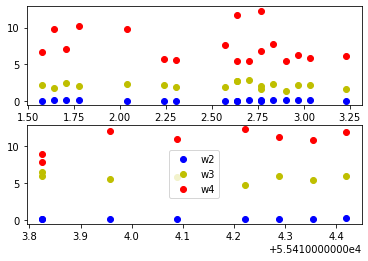

In [93]:
time = np.loadtxt(f'mba.dat.{name}')
mjdtime = time-2400000.5
obsdat = np.loadtxt(f'obs.txt.{name}')
n3 = len(obsdat)//3
w2 = obsdat[:n3]
w3 = obsdat[n3:n3*2]
w4 = obsdat[n3*2:]
plt.subplot(2,1,1)
plt.plot(mjdtime[:n3//2+5],w2[:n3//2+5],'bo',label='w2')
plt.plot(mjdtime[:n3//2+5],w3[:n3//2+5],'yo',label='w3')
plt.plot(mjdtime[:n3//2+5],w4[:n3//2+5],'ro',label='w4')
plt.subplot(2,1,2)
plt.plot(mjdtime[n3//2+5:],w2[n3//2+5:],'bo',label='w2')
plt.plot(mjdtime[n3//2+5:],w3[n3//2+5:],'yo',label='w3')
plt.plot(mjdtime[n3//2+5:],w4[n3//2+5:],'ro',label='w4')
plt.legend()
y = obsdat

## model

In [103]:
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf = theta
    astp,obsp = x
    lamda2,lamda3,lamda4 = lamda
    #print('k',astp)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    flux = np.zeros(n3*3)
    for i in range(n3):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = fluxi + wf*frLambi + frLommi
        print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n3,n3*2):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = fluxi 
        print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    for i in range(n3*2,n3*3):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A,Hv)
        flux[i] = fluxi     
        print(f'{i}:ast{astp[i]} obs{obsp[i]} flux {flux[i]}')
    return flux    

In [104]:
xast = np.vstack((ast,ast,ast))
xear  =  np.vstack((ear,ear,ear))
xt = (xast,xear)
flux = Model_neatm_Ref_jhx((1.5,250,0.5),xt,(4.6,12,22))


0:ast[-0.38473992 -0.93715529 -0.25029196] obs[-4.42215554e-01 -9.11219473e-01  2.54760249e-05] flux 1.0813892117210993
1:ast[-0.38386187 -0.93765992 -0.25026701] obs[-4.41209203e-01 -9.11720173e-01  2.54692573e-05] flux 1.0815488969127753
2:ast[-0.38298507 -0.93816252 -0.25024181] obs[-4.40204238e-01 -9.12218781e-01  2.54618458e-05] flux 1.0817108836456464
3:ast[-0.38210613 -0.93866502 -0.25021629] obs[-4.39196784e-01 -9.12717222e-01  2.54537667e-05] flux 1.0818757980403573
4:ast[-0.37858944 -0.9406624  -0.25011143] obs[-4.35165462e-01 -9.14697722e-01  2.54150559e-05] flux 1.0825609586881277
5:ast[-0.37594826 -0.94214872 -0.25002983] obs[-4.32137310e-01 -9.16170710e-01  2.53794421e-05] flux 1.08310212476768
6:ast[-0.37506587 -0.94264266 -0.25000202] obs[-4.31125555e-01 -9.16660065e-01  2.53663292e-05] flux 1.0832879907125914
7:ast[-0.37153549 -0.94460581 -0.24988807] obs[-4.27077140e-01 -9.18604219e-01  2.53079666e-05] flux 1.0840569711308965
8:ast[-0.37065269 -0.94509345 -0.24985891]